In [2]:
import sys
import os 
import tqdm
import pickle
import numpy as np 
import pandas as pd
import networkx as nx
import seaborn as sns
from functools import partial

import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# Makes the dataset that stores as the figures and data as it is generated.
if not os.path.exists("Datasets"):
    os.mkdir("Datasets")

# Version information is printed down the bottom of the jupyter notebook so that everything is imported first.

In [3]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

darkmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"}

lightmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"}

mpl.rcParams.update(lightmode)

p = plt.rcParams

# former facecolor = #f9f9f9

p["figure.facecolor"] = "#ffffff"

p["axes.linewidth"] = 1
p["axes.facecolor"] = "#f9f9f9"
p["axes.ymargin"] = 0.1
p["axes.spines.bottom"] = True
p["axes.spines.left"] = True
p["axes.spines.right"] = False
p["axes.spines.top"] = False
p["font.sans-serif"] = ["Fira Sans Condensed"]

p["axes.grid"] = False
p["grid.color"] = "black"
p["grid.linewidth"] = 0.1

p["xtick.bottom"] = True
p["xtick.top"] = False
p["xtick.direction"] = "out"
p["xtick.major.size"] = 5
p["xtick.major.width"] = 1
p["xtick.minor.size"] = 3
p["xtick.minor.width"] = 0.5
p["xtick.minor.visible"] = True
p["xtick.labelsize"] = 24

p["ytick.left"] = True
p["ytick.right"] = False
p["ytick.direction"] = "out"
p["ytick.major.size"] = 5
p["ytick.major.width"] = 1
p["ytick.minor.size"] = 3
p["ytick.minor.width"] = 0.5
p["ytick.minor.visible"] = True
p["ytick.labelsize"] = 24

p["lines.linewidth"] = 2
p["lines.marker"] = None
p["lines.markeredgewidth"] = 1.5
p["lines.markeredgecolor"] = "auto"
p["lines.markerfacecolor"] = "white"
p["lines.markersize"] = 6


In [4]:
df_freesolv = pd.read_csv("Datasets/FreeSolv.csv")
df_bace = pd.read_csv("Datasets/BACE.csv")

In [59]:
import chemprop

from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def dirichlet(signal, adj, preprocess=True):
    if preprocess:
        #signal = StandardScaler().fit_transform(signal.to_numpy().reshape(-1,1))
        #signal += np.min(signal)
        #signal = signal.flatten()
        signal=normalise(signal)
    return signal.T @ adj @ signal

def lap(adjacency):
    """
    Computes the Laplacian from a given adjacency matrix 
    """
    adj = np.copy(adjacency)
    np.fill_diagonal(adj,0)
    adj *= -1
    np.fill_diagonal(adj,np.sum(adj,0)*-1)
    return adj 

def normalise(x):
    return x/np.linalg.norm(x)

def mpnn_on_dataset(dset, epochs=30):
    
    df = pd.read_csv(f"Datasets/{dset}.csv")

    # Initialisation
    arguments = [
        '--data_path', f'Datasets/{dset}.csv',
        '--dataset_type', 'regression',
        '--epochs', '1',
        '--save_dir', f'Neural/{dset}/Epoch_0',
        '--save_smiles_splits',
        '--quiet',
    ]
    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

    scores = [mean_score]

    try:
        os.mkdir(f"Neural/{dset}")
    except OSError as error:
        pass 

    for i in range(1,epochs+1):
        current_dir = f"Neural/{dset}/Epoch_{i}"
        try:
            os.mkdir(current_dir)
        except:
            pass
        arguments = [
        '--data_path', f'Neural/{dset}/Epoch_0/fold_0/train_full.csv',
        '--dataset_type', 'regression',
        '--epochs', '1',
        '--save_dir', f'Neural/{dset}/Epoch_{i}',
        '--checkpoint_path', f"Neural/{dset}/Epoch_{i-1}/fold_0/model_0/model.pt",
        '--quiet',
        '--separate_test_path', f'Neural/{dset}/Epoch_0/fold_0/test_full.csv',
        '--separate_val_path', f'Neural/{dset}/Epoch_0/fold_0/val_full.csv',
        ]
        args = chemprop.args.TrainArgs().parse_args(arguments)
        mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
        scores.append(mean_score)
    
    return scores, df

def compute_dirichlets(dset, prop, epochs=30):

    dirichlets = []
    train_df = pd.read_csv(f'Neural/{dset}/Epoch_0/fold_0/train_full.csv')
    val_df = pd.read_csv(f'Neural/{dset}/Epoch_0/fold_0/val_full.csv')
    print(f'Neural/{dset}/Epoch_0/fold_0/train_full.csv')


    for i in range(0,epochs+1):
        model = chemprop.utils.load_checkpoint(f"Neural/{dset}/Epoch_{i}/fold_0/model_0/model.pt")
        freesolv_fps = model.fingerprint([[x] for x in train_df["SMILES"]])
        dirichlets.append(dirichlet(train_df[prop], lap(RBF(1)(freesolv_fps.detach().numpy()))))
        
    return dirichlets

def plot_training_run(scores, dirichlets, epochs=30, dset=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
    
    ax.plot(scores, dirichlets, c="k", alpha=0.25)
    ax.scatter(scores, dirichlets, marker="o", c=[tuple([(epochs-(x))/epochs for _ in range(3)]) for x in range(epochs+1)], alpha=1, edgecolor="k")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylabel("Dirichlet Energy", fontsize=24)
    ax.set_xlabel("Test RMSE", fontsize=24)
    
    ax.set_title(dset, fontsize=28)
    
    return ax

In [51]:
cleaned_harvard = pd.read_csv("Datasets/Harvard_Organic_Photovoltaic.csv")
cleaned_harvard = cleaned_harvard.iloc[np.where(~cleaned_harvard["PCE"].isna())]
cleaned_harvard.to_csv("Datasets/Harvard_Organic_Photovoltaic_cleaned.csv", index=False)

In [68]:
results = {}
epochs = 30

for dset,prop in zip(["FreeSolv", "Harvard_Organic_Photovoltaic_cleaned", "Lipophilicity", "BACE"], ["expt","PCE", "exp", "pIC50"]):
    scores, df = mpnn_on_dataset(dset, epochs=epochs)
    dirichlets = compute_dirichlets(dset, prop, epochs=epochs)
    
    results[dset] = (scores, dirichlets)

642it [00:00, 133277.73it/s]
100%|█████████████████████████████████████| 642/642 [00:00<00:00, 197183.89it/s]
Fold 0
642it [00:00, 400705.83it/s]
 55%|████████████████████████                    | 6/11 [00:00<00:00, 50.85it/s]
                                                                                
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]
Model 0 best validation rmse = 3.400091 on epoch 0
Model 0 test rmse = 3.642655                                                    
Ensemble test rmse = 3.642655
1-fold cross validation
	Seed 0 ==> test rmse = 3.642655
Overall test rmse = 3.642655 +/- 0.000000
Elapsed time = 0:00:01
513it [00:00, 265180.92it/s]
100%|█████████████████████████████████████| 513/513 [00:00<00:00, 191039.51it/s]
Fold 0
65it [00:00, 169545.87it/s]
100%|███████████████████████████████████████| 65/65 [00:00<00:00, 177956.76it/s]
64it [00:00, 115804.77it/s]
 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 48.

Neural/FreeSolv/Epoch_0/fold_0/train_full.csv
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained para

343it [00:00, 79142.16it/s]
100%|█████████████████████████████████████| 343/343 [00:00<00:00, 146085.12it/s]
Fold 0
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
71it [00:00, 91968.99it/s]
 67%|██████████████████████████████               | 4/6 [00:00<00:00, 16.93it/s]
                                                                                
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]
Model 0 best validation rmse = 2.900050 on epoch 0
Model 0 test rmse = 2.351950                                                    
Ensemble test rmse = 2.351950
1-fold cross validation
	Seed 0 ==> test rmse = 2.351950
Overall test rmse = 2.351950 +/- 0.000000
Elapsed time = 0:00:01
274it [00:00, 95953.85it/s]
100%|█████████████████████████████████████| 274/274 [00:00<00:00, 139912.26it/s]
Fold 0
35it [00:00, 137840.98it/s]
100%|███████████████████████████████████████|

Neural/Harvard_Organic_Photovoltaic_cleaned/Epoch_0/fold_0/train_full.csv
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weig

4200it [00:00, 307414.44it/s]
100%|███████████████████████████████████| 4200/4200 [00:00<00:00, 170070.54it/s]
Fold 0
4200it [00:00, 378441.57it/s]
 97%|█████████████████████████████████████████▋ | 66/68 [00:02<00:00, 27.81it/s]
                                                                                
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]
Model 0 best validation rmse = 1.149705 on epoch 0
Model 0 test rmse = 1.192673                                                    
Ensemble test rmse = 1.192673
1-fold cross validation
	Seed 0 ==> test rmse = 1.192673
Overall test rmse = 1.192673 +/- 0.000000
Elapsed time = 0:00:03
3360it [00:00, 290030.28it/s]
100%|███████████████████████████████████| 3360/3360 [00:00<00:00, 164262.04it/s]
Fold 0
420it [00:00, 153744.78it/s]
100%|█████████████████████████████████████| 420/420 [00:00<00:00, 137004.80it/s]
420it [00:00, 156866.22it/s]
 97%|█████████████████████████████████████████▋ | 66/68 [00:02<00:00

Neural/Lipophilicity/Epoch_0/fold_0/train_full.csv
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained

1513it [00:00, 146291.57it/s]
100%|███████████████████████████████████| 1513/1513 [00:00<00:00, 127429.36it/s]
Fold 0
1513it [00:00, 374217.59it/s]
 92%|███████████████████████████████████████▌   | 23/25 [00:01<00:00, 21.16it/s]
                                                                                
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]
Model 0 best validation rmse = 1.407856 on epoch 0
Model 0 test rmse = 1.379907                                                    
Ensemble test rmse = 1.379907
1-fold cross validation
	Seed 0 ==> test rmse = 1.379907
Overall test rmse = 1.379907 +/- 0.000000
Elapsed time = 0:00:02
1210it [00:00, 270600.26it/s]
100%|███████████████████████████████████| 1210/1210 [00:00<00:00, 155373.13it/s]
Fold 0
152it [00:00, 232591.83it/s]
100%|█████████████████████████████████████| 152/152 [00:00<00:00, 158788.10it/s]
151it [00:00, 241456.31it/s]
 96%|█████████████████████████████████████████▎ | 24/25 [00:01<00:00

Neural/BACE/Epoch_0/fold_0/train_full.csv
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained paramete

In [65]:
dset ="Harvard_Organic_Photovoltaic_cleaned"
prop = "PCE"
epochs = 20
scores, df = mpnn_on_dataset(dset, epochs=epochs)
dirichlets = compute_dirichlets(dset, prop, epochs=epochs)

343it [00:00, 73920.78it/s]
100%|█████████████████████████████████████| 343/343 [00:00<00:00, 128691.86it/s]
Fold 0
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
71it [00:00, 63092.28it/s]
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.79it/s]
                                                                                
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]
Model 0 best validation rmse = 2.900050 on epoch 0
Model 0 test rmse = 2.351950                                                    
Ensemble test rmse = 2.351950
1-fold cross validation
	Seed 0 ==> test rmse = 2.351950
Overall test rmse = 2.351950 +/- 0.000000
Elapsed time = 0:00:01
274it [00:00, 148193.33it/s]
100%|██████████████████████████████████████| 274/274 [00:00<00:00, 91144.36it/s]
Fold 0
35it [00:00, 59027.20it/s]
100%|████████████████████████████████████████

Neural/Harvard_Organic_Photovoltaic_cleaned/Epoch_0/fold_0/train_full.csv
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weig

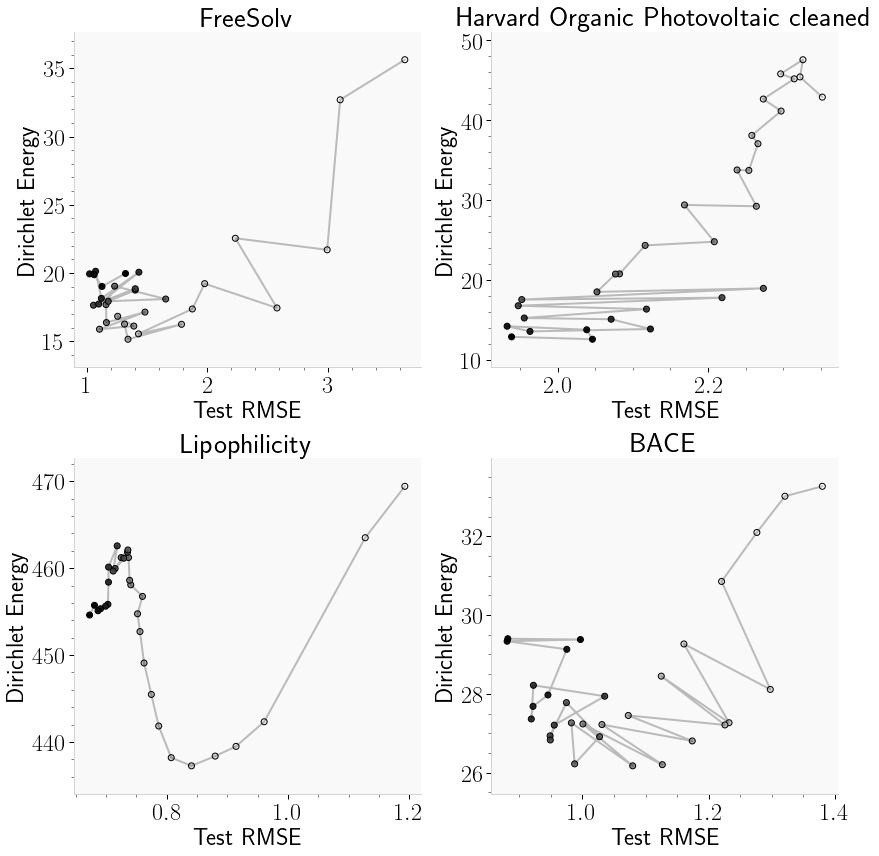

In [73]:
cols, rows = 2,2
cols_height = 6
rows_width = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,key in enumerate(results):
    x,y = np.where(coords == idx)
    x, y = x[0], y[0]
    ax = axs[x][y]

    plot_training_run(results[key][0], results[key][1], dset=key.replace("_", " "), epochs=30, ax=ax)

plt.tight_layout()
#plot_training_run(scores, dirichlets, dset="BACE")
plt.savefig("Neural_Network_Dirichlet.svg", bbox_inches="tight")
plt.savefig("Neural_Network_Dirichlet.pdf", bbox_inches="tight")

In [30]:
results

{'FreeSolv': ([3.642654836692229, 3.104918583010707, 2.9969231422835785],
  [35.622265321821324, 32.68712163333834, 21.703745342386185]),
 'Harvard_Organic_Photovoltaic': ([2.7288761158974024,
   2.7515577132508593,
   2.7008514865742965],
  [nan, nan, nan]),
 'Lipophilicity': ([1.1926730503431366,
   1.1273982592876846,
   0.9608201991118975],
  [469.4162536970115, 463.50133899095295, 442.32385100388166]),
 'BACE': ([1.379907355376028, 1.3206873170145115, 1.276243892913006],
  [33.26927240914806, 33.01761148009809, 32.09863466462867])}

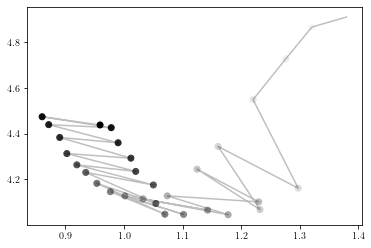

In [161]:
def plot_training_run(scores, dirichlets, epochs=30, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
    
    ax.plot(scores, dirichlets, c="k", alpha=0.25)
    ax.scatter(scores, dirichlets, marker="o", c=[tuple([(epochs-x)/epochs for _ in range(3)] + [0]) for x in range(epochs+1)], alpha=1)
    
    return ax
